In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
sns.color_palette("hls", 17)
import scipy.stats as st
import math

from pingouin import rcorr
import pingouin as pg

from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn import svm 
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, plot_roc_curve, roc_curve, auc, roc_auc_score,precision_recall_curve,multilabel_confusion_matrix,hamming_loss
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn import feature_selection #import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [2]:
import sys
import os

from sys import platform
if platform == "darwin":
    sys.path.append(os.path.dirname(os.path.realpath(__file__)) + "/..")
    smart_nlp_path = ''
elif platform == "win32":
    sys.path.append('../')
    smart_nlp_path = os.getcwd()
    smart_nlp_path = "\\".join([smart_nlp_path.split("\\")[i] for i in range(0,len(smart_nlp_path.split("\\"))-1)]+["/"])

from module.trend_analysis_functions import *
from module.topic_model_plus_class import Topic_Model_plus

In [3]:
test_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_sitreps_test.csv')).drop(["Unnamed: 0"], axis=1)
train_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_sitreps_train.csv')).drop(["Unnamed: 0"], axis=1)
val_data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_sitreps_val.csv')).drop(["Unnamed: 0"], axis=1)
data = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()),'data','ICS_predictive_summaryreps.csv')).drop(["Unnamed: 0"], axis=1)

C:\Users\srandrad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3050: DtypeWarning: Columns (7,13,18,19,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
data

,INCIDENT_ID,INCIDENT_NUMBER,INCIDENT_NAME,INCTYP_ABBREVIATION,FINAL_ACRES,CAUSE,COMPLEX,DISCOVERY_DATE,DISCOVERY_DOY,EXPECTED_CONTAINMENT_DATE,...,Livestock,Law_Violations,Military_Base,Infrastructure,Extreme_Weather,Ecological,Hazardous_Terrain,Floods,Dry_Weather,Severity
0,2000_CA-RRU-062485_VALLEY COMPLEX,CA-RRU-062485,VALLEY COMPLEX,WF,1312.0,L,True,2010-07-15 15:00:00,196,2010-07-18 00:00:00,...,0,0,0,0,1,0,1,0,0,1
1,2005_OK-CHA-005077_WILLIS,OK-CHA-005077,WILLIS,WF,460.0,H,False,2005-12-30 00:00:00,1,2006-01-05 16:00:00,...,0,0,0,0,0,0,0,0,0,1
2,2006_00276_MILLER COMPLEX,00276,MILLER COMPLEX,WF,300.0,L,True,2006-06-26 19:55:00,177,2006-07-03 18:00:00,...,0,0,0,0,0,1,0,0,0,0
3,2006_1224_MULTIPLE JUNE FIRES,1224,MULTIPLE JUNE FIRES,WF,21.0,L,False,2006-06-26 15:00:00,177,2006-07-01 18:00:00,...,0,0,0,0,0,0,1,0,0,0
4,2006_AK-DAS-612166_JARVIS CREEK,AK-DAS-612166,JARVIS CREEK,WF,275.0,H,False,2006-06-08 11:13:00,159,2006-06-13 23:59:00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9866,2014_VAVAS1406037_AIRPORT MOUNTAIN,VAVAS1406037,Airport Mountain,WF,200.0,H,False,2014-03-19 14:00:00,78,NaN,...,0,0,0,0,0,0,0,0,0,0
9867,2014_VAVAS1406040_BAKERS RIDGE,VAVAS1406040,Bakers Ridge,WF,100.0,H,False,2014-03-22 12:00:00,81,NaN,...,0,0,0,0,0,0,0,0,0,0
9868,2014_VAVAS1406041_NEIGHBOR TRAIL,VAVAS1406041,Neighbor Trail,WF,180.0,H,False,2014-03-21 12:00:00,80,NaN,...,0,0,0,0,0,0,0,0,0,0
9869,2014_VAVAS1406043_PINE CREEK,VAVAS1406043,Pine Creek,WF,150.0,H,False,2014-03-21 13:00:00,80,NaN,...,0,0,0,0,0,0,0,0,0,0


In [5]:
predictors = ["TOTAL_PERSONNEL", "TOTAL_AERIAL", "PCT_CONTAINED_COMPLETED",
              "ACRES",  "WF_FSR", "INJURIES", "FATALITIES", "EST_IM_COST_TO_DATE", "STR_DAMAGED",
              "STR_DESTROYED", "NEW_ACRES", "EVACUATION_IN_PROGRESS", 
              "NUM_REPORTS", "DAYS_BURING", 'Combined_Text', 'Incident_region_AICC', 
              'Incident_region_CA', 'Incident_region_EACC','Incident_region_GBCC', 'Incident_region_HICC', 
              'Incident_region_NRCC','Incident_region_NWCC', 'Incident_region_RMCC', 'Incident_region_SACC',
              'Incident_region_SWCC', 'INC_MGMT_ORG_ABBREV_1', 'INC_MGMT_ORG_ABBREV_2','INC_MGMT_ORG_ABBREV_3', 
              'INC_MGMT_ORG_ABBREV_4','INC_MGMT_ORG_ABBREV_5', 'INC_MGMT_ORG_ABBREV_B','INC_MGMT_ORG_ABBREV_C', 
              'INC_MGMT_ORG_ABBREV_D','INC_MGMT_ORG_ABBREV_E', 'INC_MGMT_ORG_ABBREV_F']
targets = ["Traffic","Command_Transitions","Evacuations", "Inaccurate_Mapping", "Aerial_Grounding", 
           "Resource_Issues", "Injuries", "Cultural_Resources","Livestock", "Law_Violations", "Military_Base", 
           "Infrastructure", "Extreme_Weather", "Ecological", "Hazardous_Terrain", "Floods", "Dry_Weather"]

In [6]:
data.columns

Index(['INCIDENT_ID', 'INCIDENT_NUMBER', 'INCIDENT_NAME',
       'INCTYP_ABBREVIATION', 'FINAL_ACRES', 'CAUSE', 'COMPLEX',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'EXPECTED_CONTAINMENT_DATE',
       'FATALITIES', 'FUEL_MODEL', 'INCIDENT_DESCRIPTION', 'INC_IDENTIFIER',
       'INJURIES_TOTAL', 'LL_CONFIDENCE', 'LL_UPDATE', 'LOCAL_TIMEZONE',
       'POO_CITY', 'POO_COUNTY', 'POO_LATITUDE', 'POO_LONGITUDE',
       'POO_SHORT_LOCATION_DESC', 'POO_STATE', 'PROJECTED_FINAL_IM_COST',
       'START_YEAR', 'SUPPRESSION_METHOD', 'STR_DAMAGED_TOTAL',
       'STR_DAMAGED_COMM_TOTAL', 'STR_DAMAGED_RES_TOTAL',
       'STR_DESTROYED_TOTAL', 'STR_DESTROYED_COMM_TOTAL',
       'STR_DESTROYED_RES_TOTAL', 'FINAL_REPORT_DATE', 'INC_MGMT_NUM_SITREPS',
       'EVACUATION_REPORTED', 'STR_THREATENED_MAX', 'STR_THREATENED_COMM_MAX',
       'STR_THREATENED_RES_MAX', 'TOTAL_AERIAL_SUM', 'TOTAL_PERSONNEL_SUM',
       'WF_PEAK_AERIAL', 'WF_PEAK_AERIAL_DATE', 'WF_PEAK_AERIAL_DOY',
       'WF_PEAK_PERSONNEL', 'WF_

C:\Users\srandrad\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


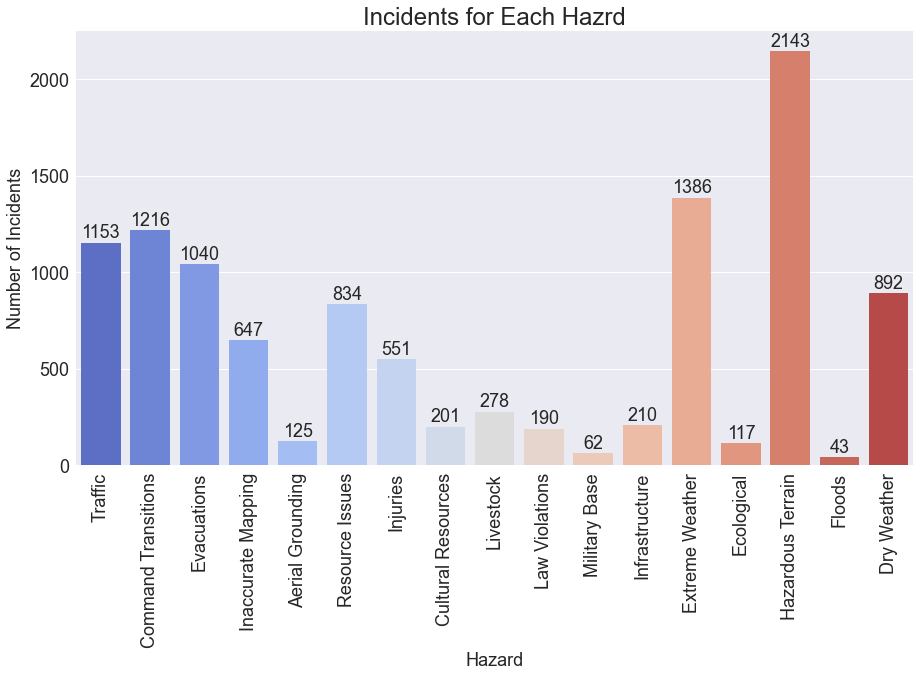

In [7]:
categories = [t.replace("_"," ") for t in targets]
counts = list(data.iloc[:,68:85].sum().values)
colors = cm.coolwarm(np.linspace(0, 1, len(categories)))
#sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, counts, palette="coolwarm")#colors=colors)
plt.title("Incidents for Each Hazrd", fontsize=24)
plt.ylabel('Number of Incidents', fontsize=18)
plt.xlabel('Hazard', fontsize=18)
ax.set_xticklabels(categories, rotation='vertical', fontsize=18)
for label in ax.get_yticklabels():
    label.set_fontsize(18)
#ax.set_xticklabels(fontsize=18)
#adding the text labels
rects = ax.patches
labels = data.iloc[:,68:85].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()


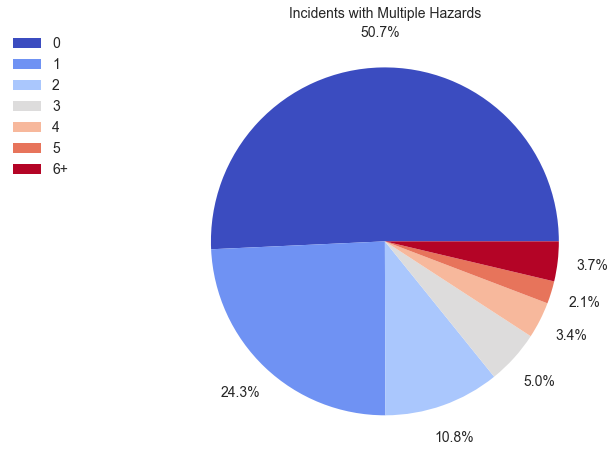

In [8]:
rowSums = data.iloc[:,68:85].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[0:]
multiLabel_counts_grouped = multiLabel_counts.iloc[0:6]
multiLabel_counts_grouped.at[6] = sum(multiLabel_counts.iloc[6:]) 
labels = [ind for ind in multiLabel_counts_grouped.index]
labels[-1] = str(labels[-1])+"+"
plt.figure(figsize=(15,8))
colors = cm.coolwarm(np.linspace(0, 1, len(labels)))
plt.pie(multiLabel_counts_grouped.values, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 14},labeldistance=None, pctdistance=1.2)
plt.title("Incidents with Multiple Hazards",fontsize=14)
plt.legend(bbox_to_anchor=(-0.2, 1),fontsize=14)
plt.show()

# Prepare the Data

In [9]:
def remove_quote_marks(word_list):
    word_list = word_list.strip("[]").split(", ")
    word_list = [w.replace("'","") for w in word_list]
    word_list = " ".join(word_list)
    return word_list

In [10]:
dfs = [train_data, val_data, test_data]
for df in dfs:
    cleaned_combined_text = []
    for text in df['Combined_Text']:
        cleaned_text = remove_quote_marks(text)
        cleaned_combined_text.append(cleaned_text)
    df['Combined_Text'] = cleaned_combined_text

In [11]:
Xtrain = train_data[predictors]; ytrain = train_data[targets]
Xval = val_data[predictors]; yval = val_data[targets]
Xtest = test_data[predictors]; ytest = test_data[targets]

## Oversampling attempts

<ipython-input-12-9f260ed8b15f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytrain['powerlabel'] = ytrain.apply(lambda x : sum([(2**i)*x[targets[i]] for i in range(len(targets))]),axis=1)


<AxesSubplot:>

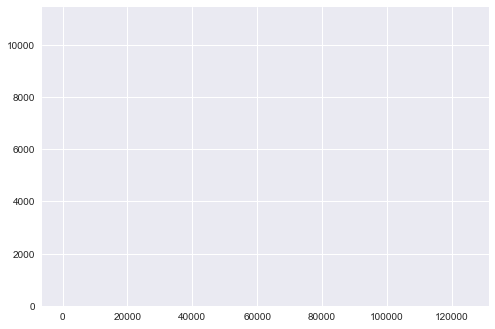

In [12]:
ytrain['powerlabel'] = ytrain.apply(lambda x : sum([(2**i)*x[targets[i]] for i in range(len(targets))]),axis=1)

ytrain['powerlabel'].hist(bins=np.unique(ytrain['powerlabel']))

In [13]:
ytrain['powerlabel'].value_counts()

0        10916
16384     1279
2          756
16386      356
1          297
         ...  
22531        1
4146         1
288          1
48           1
82351        1
Name: powerlabel, Length: 497, dtype: int64

In [14]:
powercount = {}
powerlabels = np.unique(ytrain['powerlabel'])
for p in powerlabels:
    powercount[p] = np.count_nonzero(ytrain['powerlabel']==p)
Xtrain_over = Xtrain
ytrain_over = ytrain
maxcount = np.max(list(powercount.values()))
for p in powerlabels:
    gapnum = maxcount - powercount[p]
    #print(gapnum)
    temp_df = Xtrain.iloc[np.random.choice(np.where(ytrain['powerlabel']==p)[0],size=gapnum)]
    Xtrain_over = Xtrain_over.append(temp_df,ignore_index=True)
    temp_df = ytrain.iloc[np.random.choice(np.where(ytrain['powerlabel']==p)[0],size=gapnum)]
    ytrain_over = ytrain_over.append(temp_df,ignore_index=True)
     
Xtrain_over = Xtrain_over.sample(frac=1).reset_index(drop=True)
ytrain_over = ytrain_over.sample(frac=1).reset_index(drop=True)

In [15]:
ytrain_over['powerlabel'].value_counts()

0        10916
20608    10916
65664    10916
53380    10916
49282    10916
         ...  
39       10916
81935    10916
38       10916
4132     10916
68039    10916
Name: powerlabel, Length: 497, dtype: int64

In [16]:
ytrain_over = ytrain_over[targets]
ytrain = ytrain_over
Xtrain = Xtrain_over

In [17]:
#check for imbalances
# import random
# num_to_sample = {}
# num_no_other_labels = {}
# for t in targets:
#     ytarget_df = ytrain.loc[ytrain[t] == 1].reset_index(drop=True)
#     num_multilabel = 0
#     for other_t in targets:
#         if t != other_t:
#             num_multilabel += len(ytarget_df.loc[ytarget_df[other_t]==1])
#             ytarget_df = ytarget_df.loc[ytarget_df[other_t]==0].reset_index(drop=True)
#     num_no_other_labels[t] = (ytrain[t].value_counts()[0]-ytrain[t].value_counts()[1])-num_multilabel
    
    
# print(num_to_sample)
# #over sample to remove inbalance
# print([ytrain[t].value_counts() for t in targets])

In [18]:
# for t in targets:
#     print(t)
#     ytarget_df = ytrain.loc[ytrain[t] == 1].reset_index(drop=True)
#     Xtarget_df = Xtrain.loc[ytrain[t] == 1].reset_index(drop=True)
#     list_indices = ytarget_df.index.to_list()
#     if num_no_other_labels[t]>0:
#         list_to_resample = random.choices(list_indices, k=num_no_other_labels[t])
#         #print(list_to_resample)
#         for ind in list_to_resample:
#             #print(ind)
#             #print(ytarget_df.iloc[ind][:])
#             Xtrain = Xtrain.append(pd.Series({"Combined_Text":Xtarget_df.loc[ind]}),ignore_index=True)
#             ytrain = ytrain.append(ytarget_df.iloc[ind][:],ignore_index=True)
# print([ytrain[t].value_counts() for t in targets])

In [19]:
positive_weights = {}
negative_weights = {}
for c in targets:
    positive_weights[c] = ytrain.shape[0]/(2*np.count_nonzero(ytrain[c]==1))
    negative_weights[c] = ytrain.shape[0]/(2*np.count_nonzero(ytrain[c]==0))
print(positive_weights)
print(negative_weights)

{'Traffic': 1.2181372549019607, 'Command_Transitions': 0.9448669201520913, 'Evacuations': 1.4532163742690059, 'Inaccurate_Mapping': 1.702054794520548, 'Aerial_Grounding': 5.6477272727272725, 'Resource_Issues': 1.7624113475177305, 'Injuries': 2.004032258064516, 'Cultural_Resources': 4.141666666666667, 'Livestock': 3.358108108108108, 'Law_Violations': 248.5, 'Military_Base': 31.0625, 'Infrastructure': 4.073770491803279, 'Extreme_Weather': 1.2875647668393781, 'Ecological': 4.601851851851852, 'Hazardous_Terrain': 0.9237918215613383, 'Floods': 6.902777777777778, 'Dry_Weather': 1.5828025477707006}
{'Traffic': 0.8481228668941979, 'Command_Transitions': 1.061965811965812, 'Evacuations': 0.7622699386503068, 'Inaccurate_Mapping': 0.707977207977208, 'Aerial_Grounding': 0.5485651214128036, 'Resource_Issues': 0.6980337078651685, 'Injuries': 0.6662198391420912, 'Cultural_Resources': 0.568649885583524, 'Livestock': 0.5874704491725768, 'Law_Violations': 0.501008064516129, 'Military_Base': 0.5081799591

## Text Classification: TF-iDF classifeier chain model

In [18]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2', max_features=10000)
vectorizer.fit(Xtrain['Combined_Text'])
Xtrain_vec = vectorizer.transform(Xtrain['Combined_Text'])
Xval_vec =  vectorizer.transform(Xval['Combined_Text'])
Xtest_vec= vectorizer.transform(Xtest['Combined_Text'])

In [19]:
#decreasing the number of features

In [20]:
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in targets:
    chi2, p = feature_selection.chi2(Xtrain_vec, ytrain[[cat]])
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [21]:
#for cat in y:
#    print("# {}:".format(cat))
#    print("  . selected features:",
#         len(dtf_features[dtf_features["y"]==cat]))
#    print("  . top features:", ",".join(
#        dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
#    print(" ")

In [22]:
vectorizer = TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(Xtrain['Combined_Text'])
Xtrain_vec = vectorizer.transform(Xtrain['Combined_Text'])
Xval_vec =  vectorizer.transform(Xval['Combined_Text'])
Xtest_vec = vectorizer.transform(Xtest['Combined_Text'])

# MetaData Model

### Preparing MetaData

In [23]:
classifier = ClassifierChain(LogisticRegression(max_iter=10000,multi_class='ovr'))
classifier.fit(Xtrain_vec, ytrain[targets])
# predict
predictions = classifier.predict(Xtest_vec)
probs = classifier.predict_proba(Xtest_vec)

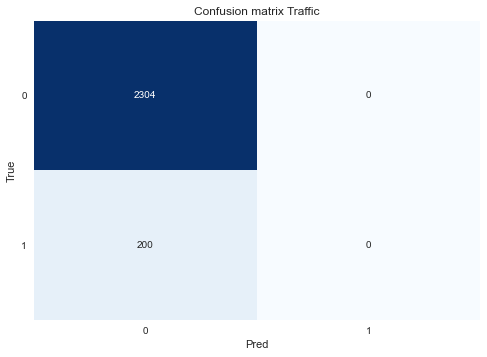

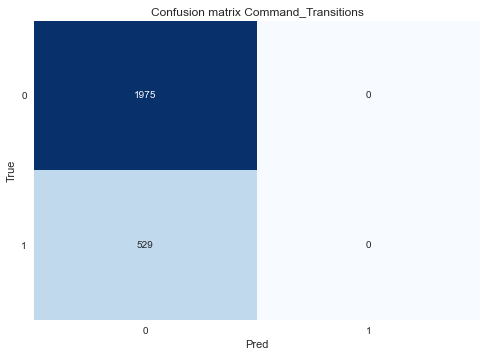

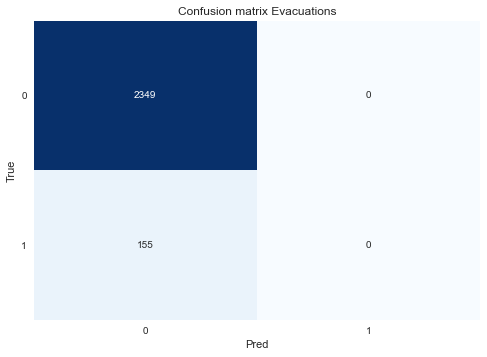

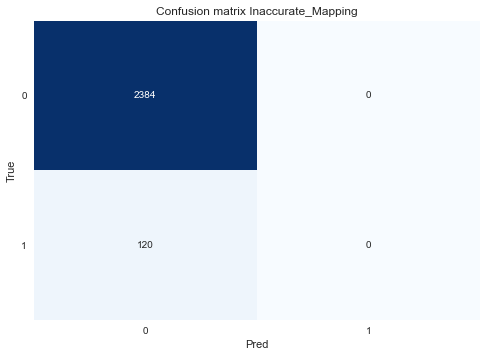

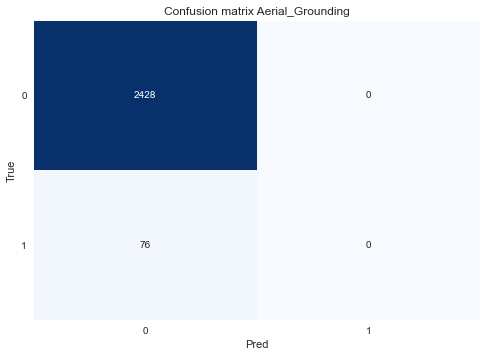

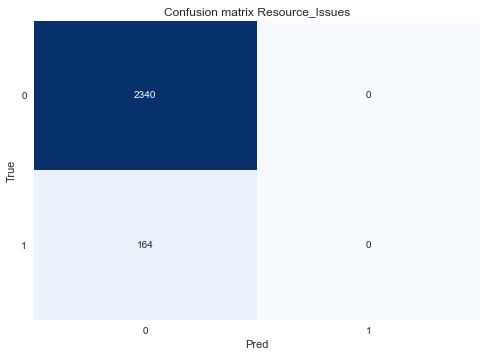

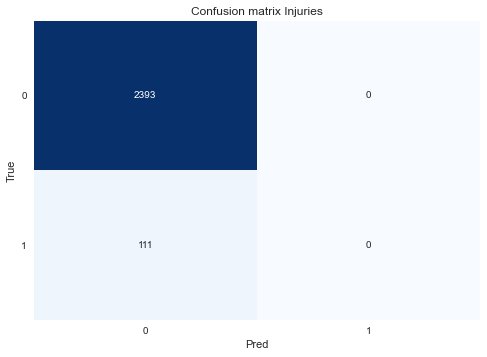

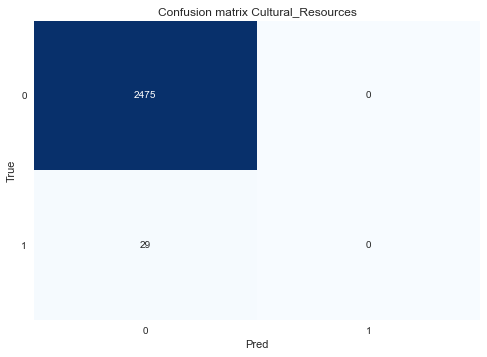

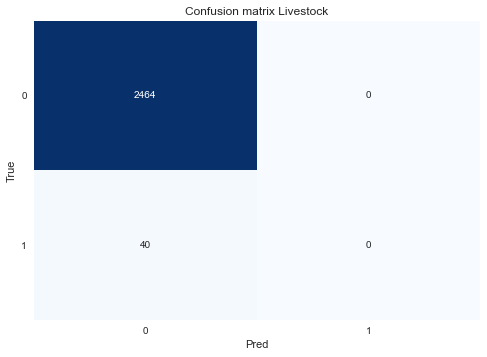

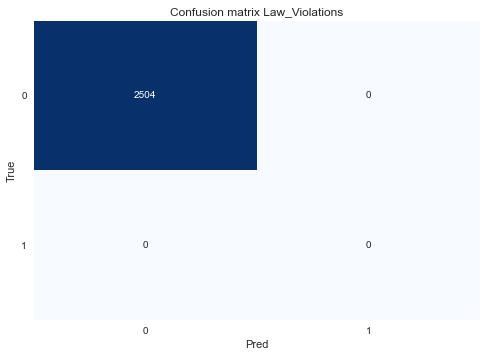

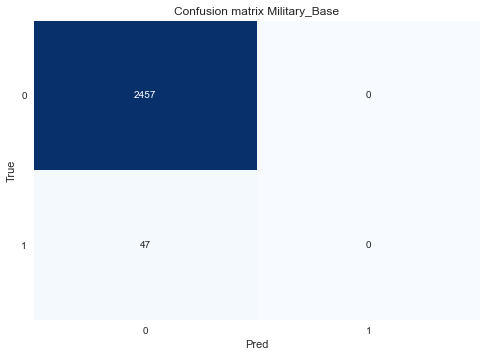

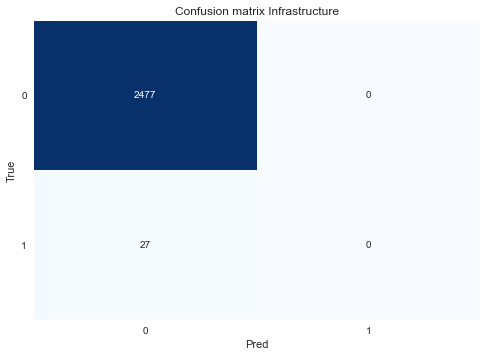

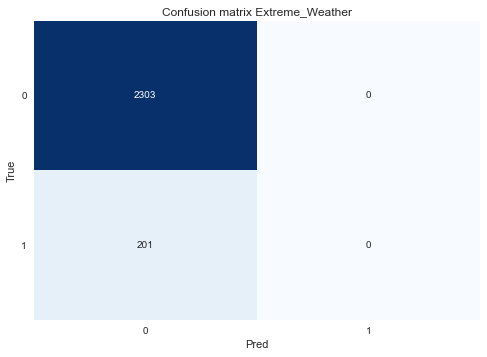

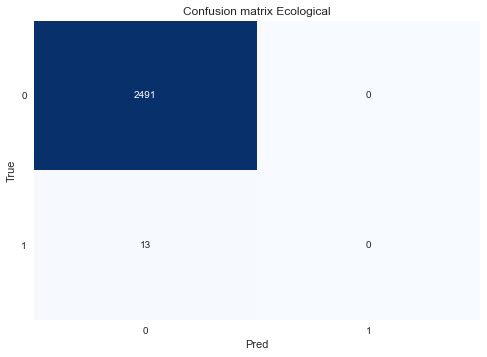

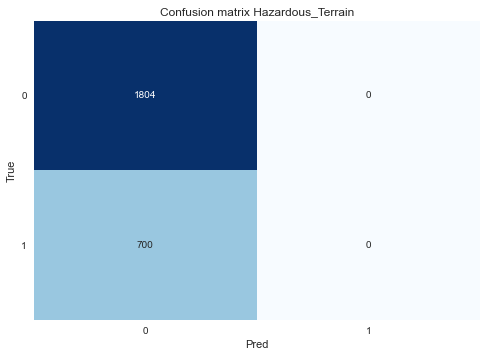

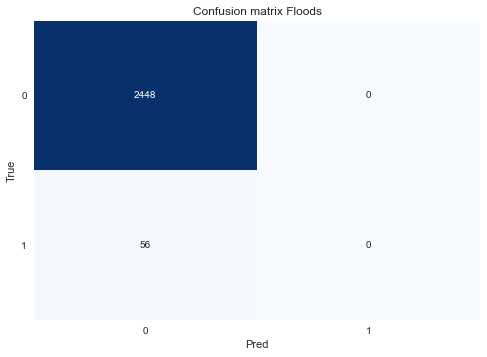

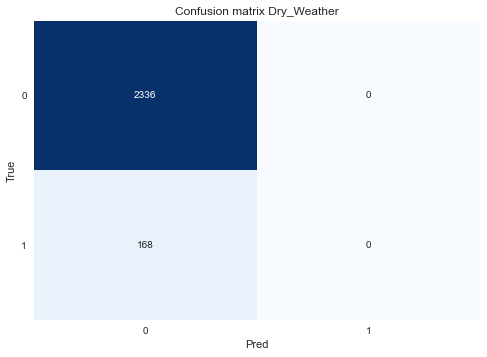

In [24]:
ml_cm = multilabel_confusion_matrix(ytest.to_numpy(), predictions)
i=0
for cm in ml_cm:
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix "+targets[i])
    plt.yticks(rotation=0)
    i+=1

In [25]:
hamming_loss(ytest[targets],predictions)

0.06192445029129863

In [26]:
probs.shape

(2504, 17)

In [27]:
training_probs = classifier.predict_proba(Xtrain_vec)

In [28]:
training_probs.shape

(5425252, 17)

In [29]:
probs_df = pd.DataFrame(training_probs, columns=targets)

In [30]:
Xtrain_meta = Xtrain.drop(["Combined_Text"],axis=1)

In [31]:
Xtrain_combined = pd.concat([Xtrain_meta, probs_df], axis=1)

In [32]:
Xtrain_combined

,TOTAL_PERSONNEL,TOTAL_AERIAL,PCT_CONTAINED_COMPLETED,ACRES,WF_FSR,INJURIES,FATALITIES,EST_IM_COST_TO_DATE,STR_DAMAGED,STR_DESTROYED,...,Cultural_Resources,Livestock,Law_Violations,Military_Base,Infrastructure,Extreme_Weather,Ecological,Hazardous_Terrain,Floods,Dry_Weather
0,0.006459,0.000000,0.000000,0.000179,0.000345,0.0,0.0,0.000960,0.0,0.0,...,0.160521,0.125149,0.035535,0.135034,0.148068,0.4505,0.122123,0.406014,0.036413,0.179276
1,0.191066,0.095238,0.000007,0.005828,0.000000,0.0,0.0,0.014978,0.0,0.0,...,0.160521,0.125149,0.035535,0.135034,0.148068,0.4505,0.122123,0.406014,0.036413,0.179276
2,0.160926,0.023810,0.000013,0.000353,0.000003,0.0,0.0,0.021864,0.0,0.0,...,0.160521,0.125149,0.035535,0.135034,0.148068,0.4505,0.122123,0.406014,0.036413,0.179276
3,0.312164,0.166667,0.000001,0.013204,0.004700,0.0,0.0,0.068168,0.0,0.0,...,0.160521,0.125149,0.035535,0.135034,0.148068,0.4505,0.122123,0.406014,0.036413,0.179276
4,0.386975,0.238095,0.000015,0.007137,0.003379,0.0,0.0,0.013442,0.0,0.0,...,0.160521,0.125149,0.035535,0.135034,0.148068,0.4505,0.122123,0.406014,0.036413,0.179276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5425247,0.050592,0.000000,0.000025,0.012984,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.160521,0.125149,0.035535,0.135034,0.148068,0.4505,0.122123,0.406014,0.036413,0.179276
5425248,0.001615,0.000000,0.000000,0.000296,0.000022,0.0,0.0,0.000480,0.0,0.0,...,0.160521,0.125149,0.035535,0.135034,0.148068,0.4505,0.122123,0.406014,0.036413,0.179276
5425249,0.006997,0.000000,0.000000,0.001210,0.002328,0.0,0.0,0.001920,0.0,0.0,...,0.160521,0.125149,0.035535,0.135034,0.148068,0.4505,0.122123,0.406014,0.036413,0.179276
5425250,0.074273,0.023810,0.000004,0.000807,0.001552,0.0,0.0,0.000442,0.0,0.0,...,0.160521,0.125149,0.035535,0.135034,0.148068,0.4505,0.122123,0.406014,0.036413,0.179276


In [33]:
classifier_meta = ClassifierChain(LogisticRegression(max_iter=10000,multi_class='ovr'))
classifier_meta.fit(Xtrain_combined, ytrain[targets])
# predict
Xtest_combined = pd.concat([Xtest.drop(["Combined_Text"],axis=1), pd.DataFrame(classifier.predict_proba(Xtest_vec), columns=targets)], axis=1)
predictions = classifier_meta.predict(Xtest_combined)

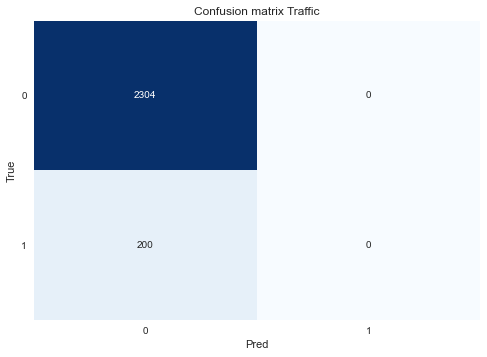

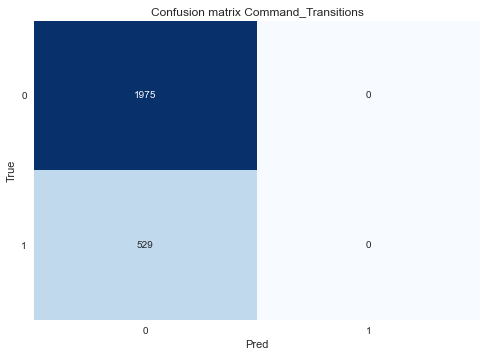

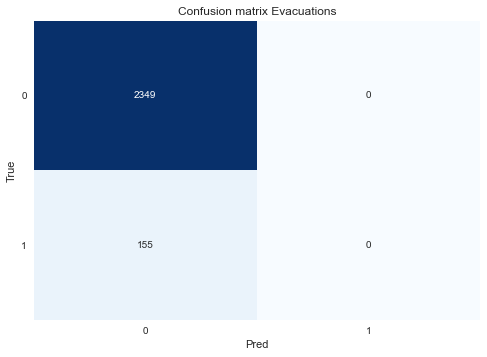

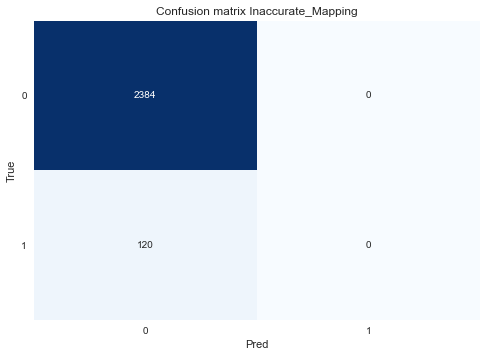

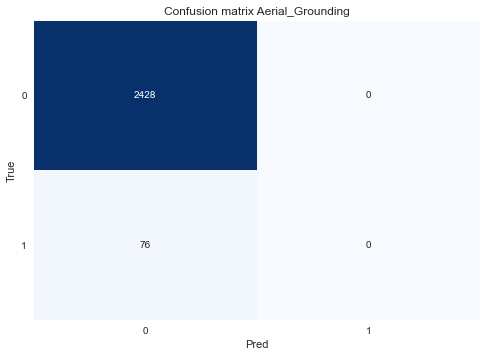

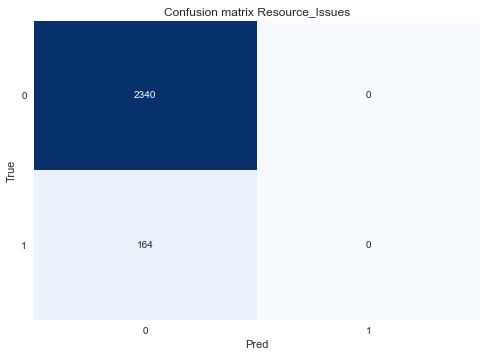

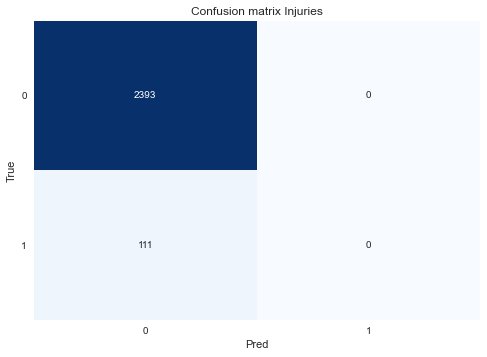

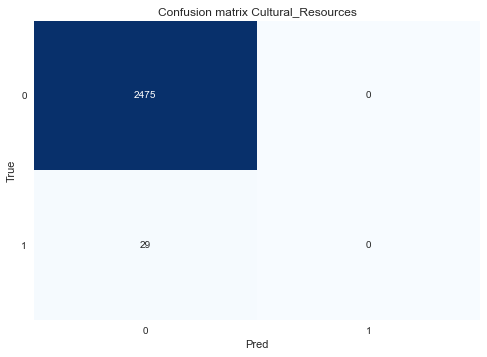

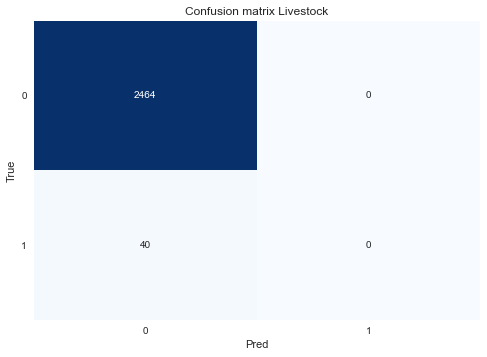

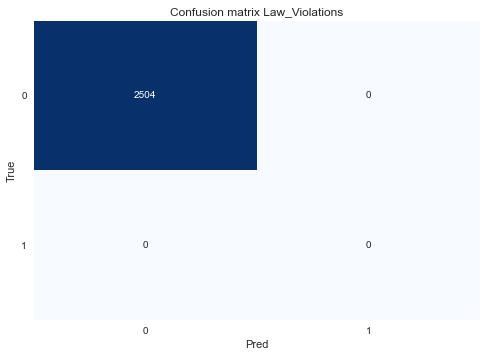

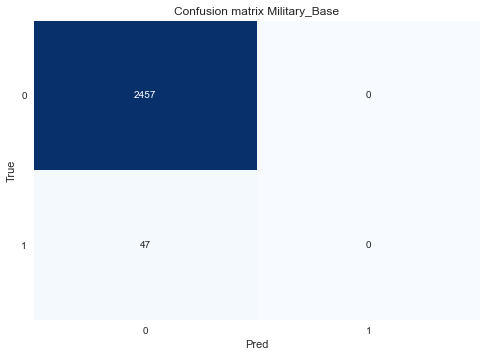

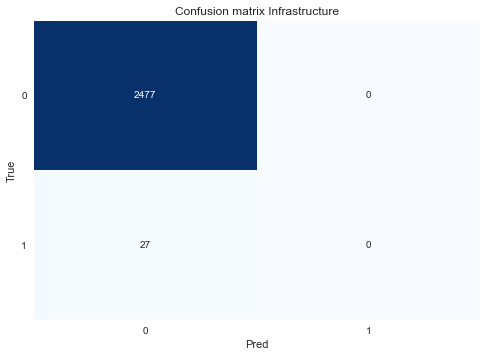

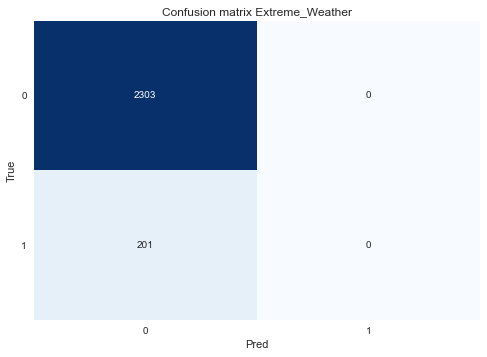

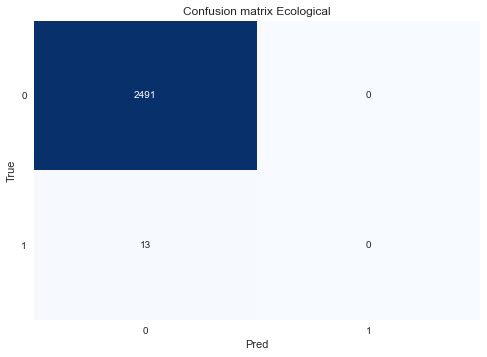

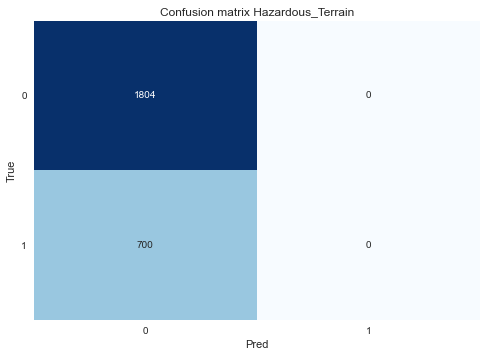

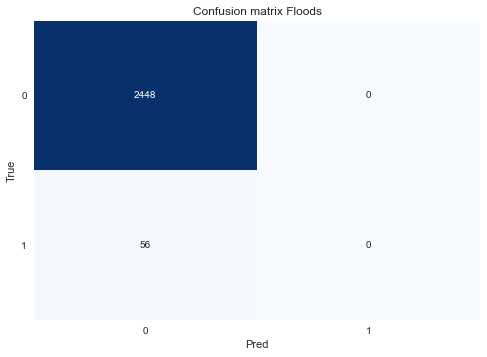

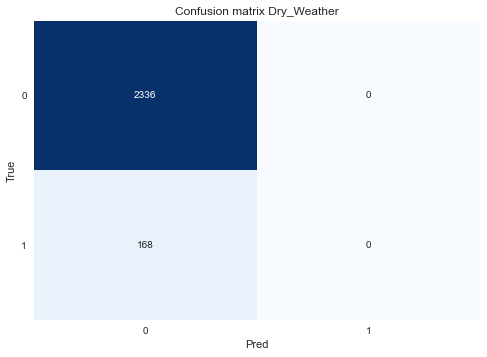

In [34]:
ml_cm = multilabel_confusion_matrix(ytest.to_numpy(), predictions)
i=0
for cm in ml_cm:
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix "+targets[i])
    plt.yticks(rotation=0)
    i+=1

In [35]:
hamming_loss(ytest[targets],predictions)

0.06192445029129863